# VILT problem

In [124]:
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
import copy
import datetime

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [126]:
sys.path.append("../../polaris/polaris")
import Keplerian as kep
import Propagator as prop
import Coordinates as coordinates

In [127]:
saturn_system_list = pxp.saturn_system()
saturn_system_list

{'titan': Planet Name: titan
 Own gravity parameter: 8978138845307.375
 Central body gravity parameter: 37940585200000000
 Planet radius: 2575000
 Planet safe radius: 3575000
 Keplerian planet elements: 
 Semi major axis (AU): 0.0081679908738070735
 Eccentricity: 0.028659655999962765
 Inclination (deg.): 0.34854000000000002
 Big Omega (deg.): 168.9804393664231
 Small omega (deg.): 187.54004751915846
 Mean anomaly (deg.): 85.473338328460613
 Elements reference epoch: 2044-Jan-01 00:00:00
 Ephemerides type: Keplerian
 r at ref. = [100498895.09619081, 1215982165.153239, -7377587.7509758044]
 v at ref. = [-5545.9127708528058, 618.65173428517164, 2.754636768065529]}

In [128]:
titan_period = saturn_system_list["titan"].compute_period(epoch(2345.3, 'mjd2000')) / 86400  # days
titan_period

15.946856899173909

In [6]:
n_rev = 4
seq = [saturn_system_list["titan"] for el in range(n_rev+1)]

tof = [
    [0.75*titan_period, 7*titan_period] for el in range(len(seq)-1)
]  # in days

In [7]:
t0 = pk.epoch_from_string('2044-12-14 00:00:00.000').mjd2000

In [8]:
vinf = 4000.0  # Titan encounter v-infinity

In [9]:
len(tof), len(seq)

(4, 5)

In [10]:
prob_titan = pxp.mga_1dsm_vilt(
    t0,
    vinf,
    seq,
    tof,
    pxp.MU_SATURN,
)

In [11]:
prob_titan.fitness(prob_titan.ub)

[80176991.86937663]

In [130]:
algo = pxp.algo_factory(choice="de", generation=6000)

In [131]:
pop_size = 30

pop = pg.population(prob=prob_titan, size=pop_size)
pop = algo.evolve(pop)

In [132]:
pop.champion_x

array([ -0.56233816,   2.98747596,   0.14188052,  41.40791826,
        -0.30543758,   7.03938261,   0.34362957, 103.01920875,
         5.83249942,  18.98284275,   0.54351255, 111.61475213,
         1.17624058,   5.61300385,   0.30653594,  34.10479597])

In [134]:
DV, r_P, v_P, vinf_final, traj_comp, dsm_info = prob_titan.evaluate_trajectory(pop.champion_x)
print(f"DSM Cost:           {np.linalg.norm(DV)}")
print(f"Arrival v-inf Cost: {np.linalg.norm(vinf_final)}")
print(f"Total Cost:         {np.linalg.norm(vinf_final) + np.linalg.norm(DV)}")

DSM Cost:           552.1173126295085
Arrival v-inf Cost: 980.5879912431413
Total Cost:         1532.70530387265


In [135]:
# unpack x
x_per_legs = []
for idx in range(len(seq)-1):
    x_per_legs.append(
        pop.champion_x[4*idx:4*idx+4]
    )

# compute tof
tofs = []
for x in x_per_legs:
    tofs.append(x[3])
print(f"TOF: {np.linalg.norm(tofs)} days")

TOF: 161.08557684530203 days


In [136]:
np.linalg.norm(DV)

552.1173126295085

In [137]:
np.linalg.norm(vinf_final)

980.5879912431413

In [138]:
def coord_mga_1dsm(traj_comp, t0, t_step):
    """Get coordinates from MGA1DSM problem"""
    # trajectory storage
    rs_list, vs_list, ts_list = [], [], []
    t_running = 0
    
    # propagate each leg
    for idx, leg in enumerate(traj_comp):
        n = int(round(leg[2]/t_step))
        ts_lambert = np.linspace(0, leg[2], n)
    
        for t in ts_lambert:
            rf,vf = pk.propagate_lagrangian(r0 = leg[0], v0 = leg[1], tof = t, mu = leg[3])
            rs_list.append(rf)
            vs_list.append(vf)
            ts_list.append(t0 + t_running/pk.DAY2SEC + t/pk.DAY2SEC)
        t_running += leg[2]
            
    # convert to array
    n_elements = len(rs_list)
    coord = np.zeros((7,n_elements))
    for idx in range(n_elements):
        coord[0, idx]  = ts_list[idx]
        coord[1:4,idx] = rs_list[idx]
        coord[4:7,idx] = vs_list[idx]
    return coord

In [139]:
# trajectory MGA
coord = coord_mga_1dsm(traj_comp, t0, t_step=3000)

In [140]:
def coord_body(planet, t0, t_step, mu):
    period = planet.compute_period(pk.epoch(t0, 'mjd2000'))
    n = int(round(period/t_step))
    ts_lambert = np.linspace(0, period, n)
    r0, v0 = planet.eph(pk.epoch(t0, 'mjd2000'))
    coord = np.zeros((6,n))
    for idx,t in enumerate(ts_lambert):
        rf,vf = pk.propagate_lagrangian(r0, v0, tof = t, mu = mu)
        coord[0:3,idx] = rf
        coord[3:6,idx] = vf
    return coord

In [141]:
titan_coord = coord_body(saturn_system_list["titan"], t0, 3000, pxp.MU_SATURN)

#SMA_TITAN = 1221914042.5450587

In [142]:
saturn_system_list["titan"]

Planet Name: titan
Own gravity parameter: 8978138845307.375
Central body gravity parameter: 37940585200000000
Planet radius: 2575000
Planet safe radius: 3575000
Keplerian planet elements: 
Semi major axis (AU): 0.0081679908738070735
Eccentricity: 0.028659655999962765
Inclination (deg.): 0.34854000000000002
Big Omega (deg.): 168.9804393664231
Small omega (deg.): 187.54004751915846
Mean anomaly (deg.): 85.473338328460613
Elements reference epoch: 2044-Jan-01 00:00:00
Ephemerides type: Keplerian
r at ref. = [100498895.09619081, 1215982165.153239, -7377587.7509758044]
v at ref. = [-5545.9127708528058, 618.65173428517164, 2.754636768065529]

In [143]:
# approach hyperbolic trajectory (for plotting)
hyperbolic_approach = np.load("./dat_hyperbolic_approach/nominal_hyperbolic.npy")

In [144]:
print(r_P[0][0]/np.linalg.norm(r_P[0]))
print(r_P[0][1]/np.linalg.norm(r_P[0]))
print(r_P[0][2]/np.linalg.norm(r_P[0]))

0.8206876124057341
-0.5713718612868323
0.0024574322771043515


In [145]:
hyperbolic_approach.shape

(2140, 7)

In [146]:
hyperbolic_approach[0, 1:4]

array([9.33409511e+08, 7.88556030e+08, 0.00000000e+00])

In [147]:
phi = np.arccos(np.dot(r_P[0], hyperbolic_approach[0, 1:4])/(np.linalg.norm(r_P[0])*np.linalg.norm(hyperbolic_approach[0, 1:4])))
#phi = np.pi - np.arctan(r_P[0][1]/r_P[0][0])

n_steps, _ = hyperbolic_approach.shape
hyperbolic_coord = np.zeros((n_steps, 3))

for idx in range(n_steps):
    r = hyperbolic_approach[idx, 1:4]
    hyperbolic_coord[idx,:] = np.dot(coordinates.rotmat_ax3(phi), r)

In [152]:
len(pop.champion_x)

16

<IPython.core.display.Javascript object>


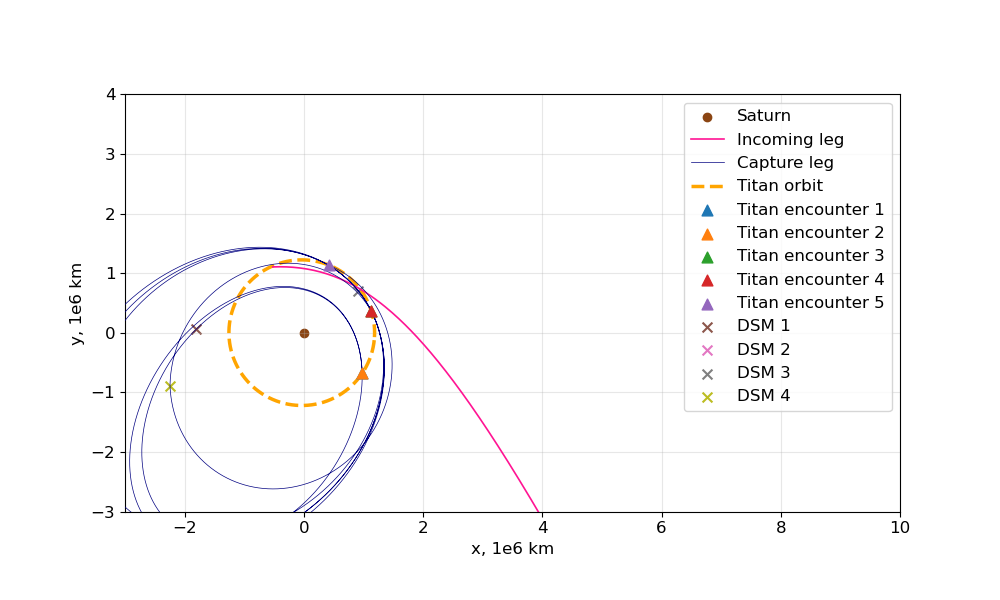

In [148]:
plt.rcParams["font.size"] = 12

lscale = 1/1e9

fig, ax = plt.subplots(1,1,figsize=(10,6))

# Saturn
ax.scatter(0,0,c="saddlebrown",marker="o",label="Saturn")

# trajectory hyperbolic
#ax.plot(hyperbolic_approach[:,1]*lscale, hyperbolic_approach[:,2]*lscale, 
#         c="deeppink", lw=2, zorder=3, label="Incoming leg")
ax.plot(hyperbolic_coord[:,0]*lscale, hyperbolic_coord[:,1]*lscale, 
        c="deeppink", lw=1.2, zorder=3, label="Incoming leg")

# trajectory in Titan
ax.plot(coord[1,:]*lscale, coord[2,:]*lscale, c="navy", lw=0.5, zorder=3, label="Capture leg")

# Titan
ax.plot(titan_coord[0,:]*lscale, titan_coord[1,:]*lscale, c="orange", lw=2.5, ls="--", label="Titan orbit")

# fly-by nodes
for i,rp in enumerate(r_P):
    ax.scatter(rp[0]*lscale, rp[1]*lscale, marker="^", s=60, label=f"Titan encounter {i+1}", zorder=3)

# DSMs
for i, dsm in enumerate(dsm_info):
    ax.scatter(dsm[0][0]*lscale, dsm[0][1]*lscale, marker="x", s=50, label=f"DSM {i+1}")

ax.set(xlabel="x, 1e6 km", ylabel="y, 1e6 km")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.legend()

ax.set_xlim([-3, 10])
ax.set_ylim([-3, 4])
plt.show()

In [149]:
#fig.savefig("./plots/titan_vilt.png")

In [100]:
pk.epoch(coord[0,-1], 'mjd2000')

2044-Dec-06 02:17:42.413256

In [116]:
_, n = coord.shape
r_saturn_spacecraft = []
epoch_list = []
dist_titan_sc = []

for idx in range(n):
    spacecraft_r = np.linalg.norm(coord[1:4,idx])
    titan_r = saturn_system_list["titan"].eph(pk.epoch(coord[0,idx], 'mjd2000'))
    
    r_saturn_spacecraft.append(spacecraft_r)
    dist_titan_sc.append(np.linalg.norm(titan_r - spacecraft_r))
    
    epoch_list.append(
        np.datetime64(
            datetime.datetime.strptime(
                pk.epoch(coord[0,idx], 'mjd2000').__str__()[0:11], 
                '%Y-%b-%d'
            ).strftime('%Y-%m-%d')
        )
    )

In [117]:
#saturn_system_list["titan"].eph(pk.epoch(coord[0,idx], 'mjd2000'))

In [119]:
coord[0,idx]

16411.095629783053

<IPython.core.display.Javascript object>


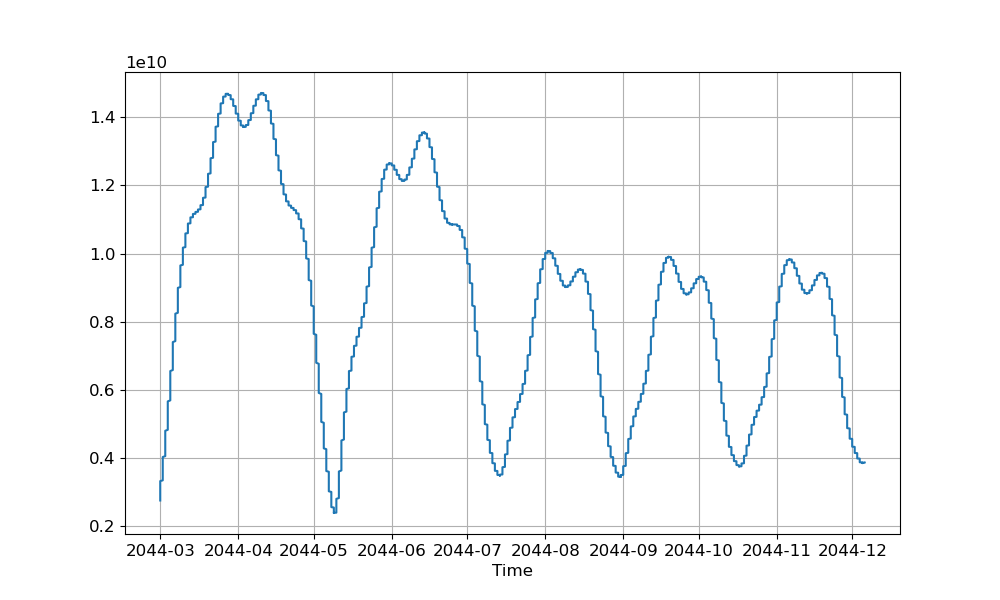

In [123]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(epoch_list, np.array(dist_titan_sc))
ax.set(xlabel="Time")
ax.grid(True)